In [11]:
from statsmodels.tsa.api import ExponentialSmoothing as HWES
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
import pandas as pd
from typing import *
import numpy as np

### Data

In [49]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
betas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gammas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
i_l = 17.417  # initial level
i_t = 0.465  # initial trend
i_s_mul = [1.09, 1.09, 1.32, 0.97, 1.03, 0.57, 0.63, 1.20, 1.72, 1.43, 0.51, 0.40]
i_s_add = [1.58, 1.58, 5.58, -0.41, 0.58, -7.41, -6.41, 3.58, 12.58, 7.58, -8.41, -10.41]

# tren, seasonal, damped trend,
model_combinations = [
    ("add", "mul", True),
    ("add", "mul", False),
    ("mul", "mul", True),
    ("mul", "mul", False),

    ("add", "add", True),
    ("add", "add", False),
    ("mul", "add", True),
    ("mul", "add", False),
]


### Init Series

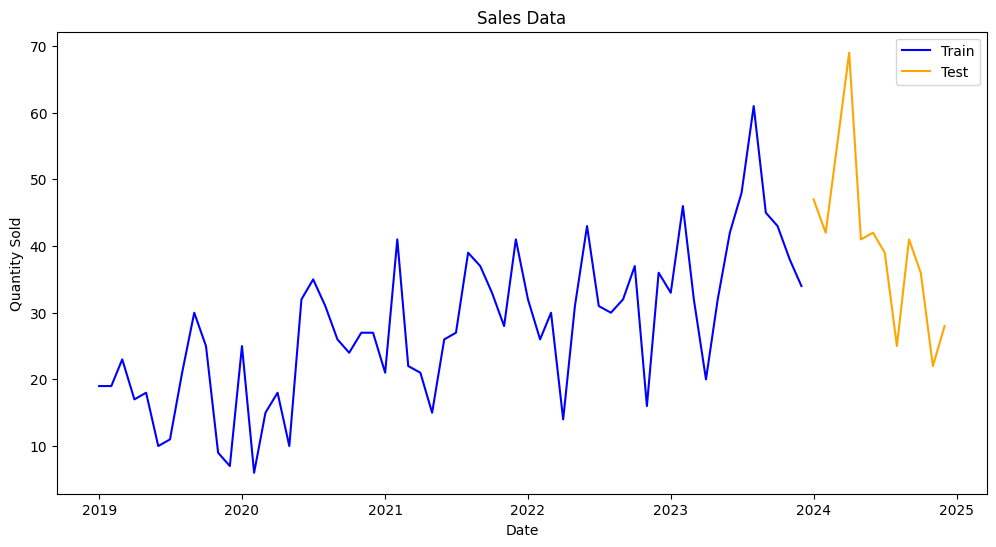

In [7]:
# create a pandas from the sales data
# the index is the date and the value is the quantity sold
original_sales = pd.read_csv("data/sales.csv", sep=",", header=0, index_col=0)
original_sales.index = pd.to_datetime(original_sales.index, format="%Y-%m")
original_sales = original_sales.asfreq('MS')

# # split the series into train and test sets, last 12 months are the test set
train_series = original_sales[:-12]
test_series = original_sales[-12:]

plt.figure(figsize=(12, 6))
plt.plot(train_series, label="Train", color="blue")
plt.plot(test_series, label="Test", color="orange")
plt.title("Sales Data")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.show()


### Finding the best model without optimization

In [67]:
best_aic = float("inf") # the lowest aic is the best model
best_mape = float("inf") # the lowest mape is the best model

# get best model based on AICc and MAPE
best_model_aic = None
best_model_mape = None
  
# fit the Holt-Winters model with manual smoothing parameters
for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            try:
                forecast_model = HWES(
                    endog=train_series, 
                    seasonal_periods=12, 
                    trend='add', 
                    seasonal='add',
                    initialization_method="known",
                    initial_level=17.41,  # initial level
                    initial_trend=i_t,  # initial trend
                    initial_seasonal=i_s_add,  # initial seasonal components (additive)
                )
                forecast_model_fit = forecast_model.fit(
                    smoothing_level=alpha,
                    smoothing_trend=beta,
                    smoothing_seasonal=gamma,
                    optimized=False,  # Disable auto-optimization
                )

                forecast = forecast_model_fit.forecast(steps=12)

                # calculate the mean absolute error percentage
                mape = mean_absolute_percentage_error(test_series, forecast)
                aic = forecast_model_fit.aic

                if aic < best_aic:
                    best_aic = aic
                    best_model_aic = forecast_model_fit
                if mape < best_mape:
                    best_mape = mape
                    best_model_mape = forecast_model_fit
            except Exception as e:
                print(f"Error: {e}")
                continue

Best Model based on AICc: 296.90448275236315
                       ExponentialSmoothing Model Results                       
Dep. Variable:                 quantity   No. Observations:                   60
Model:             ExponentialSmoothing   SSE                           4961.281
Optimized:                        False   AIC                            296.904
Trend:                         Additive   BIC                            330.414
Seasonal:                      Additive   AICC                           313.587
Seasonal Periods:                    12   Date:                 Sat, 12 Apr 2025
Box-Cox:                          False   Time:                         22:24:25
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha  

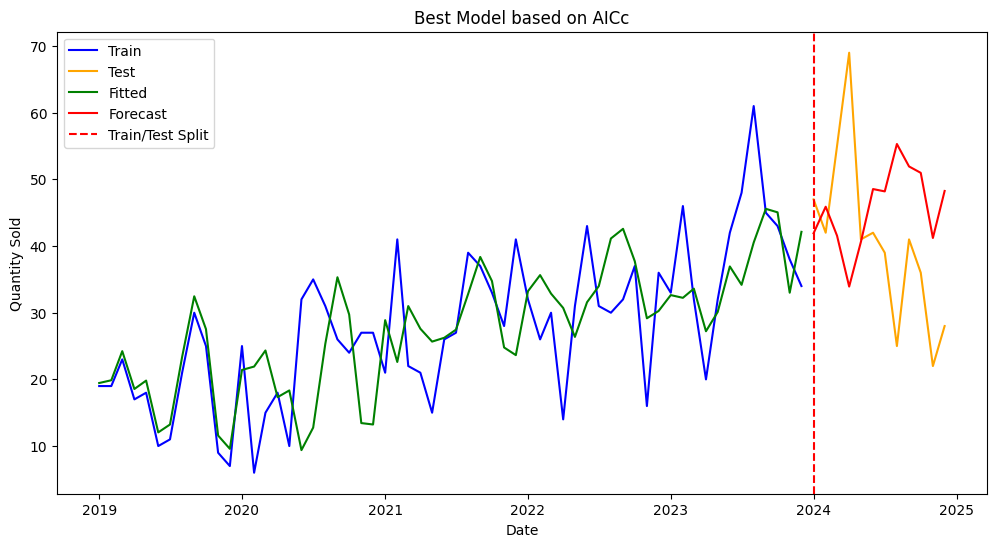

In [69]:
# print the best model based on AICc and MAPE
print("Best Model based on AICc: " + str(best_aic))
print(best_model_aic.summary())
print("===========================================")
# plot the best model based on AICc
plt.figure(figsize=(12, 6))
plt.plot(train_series, label="Train", color="blue")
plt.plot(test_series, label="Test", color="orange")
plt.plot(best_model_aic.fittedvalues, label="Fitted", color="green")
plt.plot(best_model_aic.forecast(steps=12), label="Forecast", color="red")
plt.axvline(x=test_series.index[0], color="red", linestyle="--", label="Train/Test Split")
plt.title("Best Model based on AICc")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.show()

Best Model based on MAPE:0.1650716815468493
                       ExponentialSmoothing Model Results                       
Dep. Variable:                 quantity   No. Observations:                   60
Model:             ExponentialSmoothing   SSE                           8367.050
Optimized:                        False   AIC                            328.263
Trend:                         Additive   BIC                            361.772
Seasonal:                      Additive   AICC                           344.946
Seasonal Periods:                    12   Date:                 Sat, 12 Apr 2025
Box-Cox:                          False   Time:                         22:24:29
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

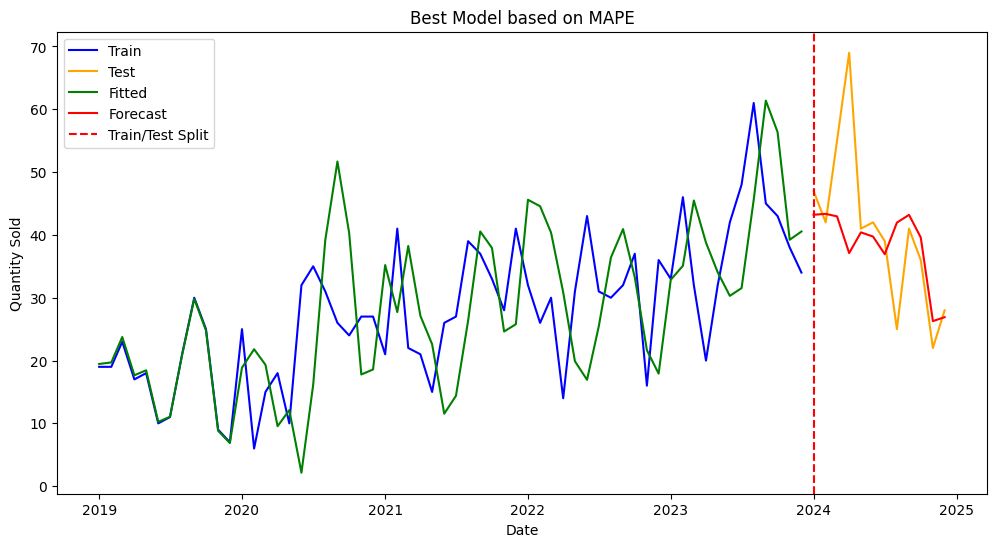

In [70]:
print("Best Model based on MAPE:" + str(best_mape))
print(best_model_mape.summary())
print("==========================================")
# plot the best model based on MAPE
plt.figure(figsize=(12, 6))
plt.plot(train_series, label="Train", color="blue")
plt.plot(test_series, label="Test", color="orange")
plt.plot(best_model_mape.fittedvalues, label="Fitted", color="green")
plt.plot(best_model_mape.forecast(steps=12), label="Forecast", color="red")
plt.axvline(x=test_series.index[0], color="red", linestyle="--", label="Train/Test Split")
plt.title("Best Model based on MAPE")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.show()

### Finding the best model with optimization

In [72]:
best_aicc = float("inf") # the lowest aic is the best model
best_mape = float("inf") # the lowest mape is the best model

best_model_aicc = None
best_model_mape = None

# fit the Holt-Winters model with auto smoothing parameters
for trend, seasonal, damped_trend in model_combinations:
    try:
        forecast_model = HWES(
            endog=train_series,
            seasonal_periods=12,
            trend=trend,
            seasonal=seasonal,
            damped_trend=damped_trend,
            initialization_method="known",
            initial_level=i_l,  # initial level
            initial_trend=i_t,  # initial trend
            initial_seasonal=i_s_mul if seasonal == "mul" else i_s_add,  # initial seasonal
        )
        forecast_model_fit = forecast_model.fit(optimized=True)
        forecast = forecast_model_fit.forecast(steps=12)
        
        # calculate the mean absolute error percentage
        mape = mean_absolute_percentage_error(test_series, forecast)
        aicc = forecast_model_fit.aic

        if aicc < best_aicc:
            best_aicc = aicc
            best_model_aicc = forecast_model_fit
        if mape < best_mape:
            best_mape = mape
            best_model_mape = forecast_model_fit
    except Exception as e:
        print(f"Error: {e}")
        continue

Best Model based on AICc: 291.5632884542875
                       ExponentialSmoothing Model Results                       
Dep. Variable:                 quantity   No. Observations:                   60
Model:             ExponentialSmoothing   SSE                           4538.716
Optimized:                         True   AIC                            291.563
Trend:                         Additive   BIC                            325.073
Seasonal:                      Additive   AICC                           308.246
Seasonal Periods:                    12   Date:                 Sat, 12 Apr 2025
Box-Cox:                          False   Time:                         22:24:52
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0166713                alpha   

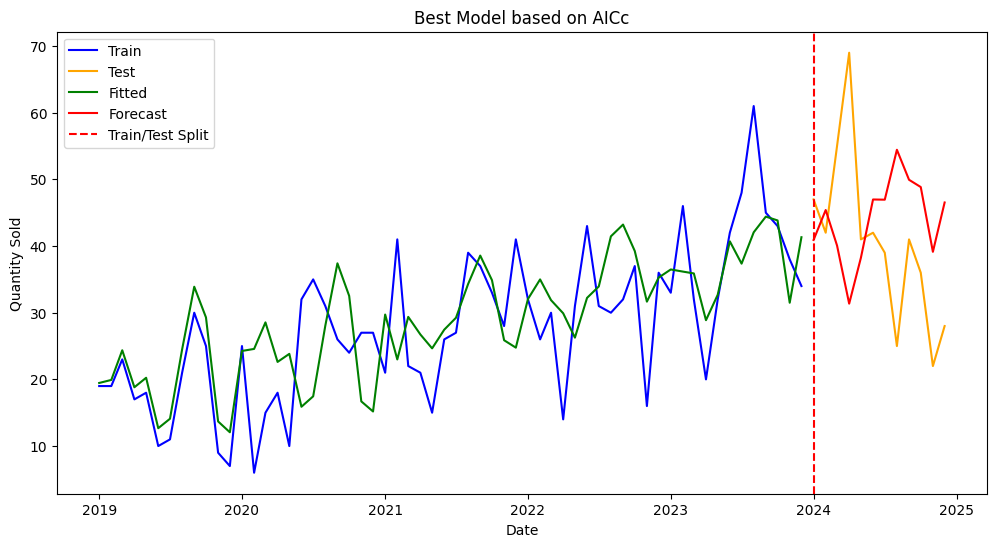

In [ ]:
# Print the best model based on AICc
print("Best Model based on AICc: " + str(best_aicc))
print(best_model_aicc.summary())

print("===========================================")
# plot the best model based on AICc
plt.figure(figsize=(12, 6))
plt.plot(train_series, label="Train", color="blue")
plt.plot(test_series, label="Test", color="orange")
plt.plot(best_model_aicc.fittedvalues, label="Fitted", color="green")
plt.plot(best_model_aicc.forecast(steps=12), label="Forecast", color="red")
plt.axvline(x=test_series.index[0], color="red", linestyle="--", label="Train/Test Split")
plt.title("Best Model based on AICc")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.show()

Best Model based on MAPE: 0.3148496505584033
                       ExponentialSmoothing Model Results                       
Dep. Variable:                 quantity   No. Observations:                   60
Model:             ExponentialSmoothing   SSE                           8103.635
Optimized:                         True   AIC                            328.343
Trend:                   Multiplicative   BIC                            363.947
Seasonal:                Multiplicative   AICC                           347.343
Seasonal Periods:                    12   Date:                 Sat, 12 Apr 2025
Box-Cox:                          False   Time:                         22:24:58
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0869022                alpha  

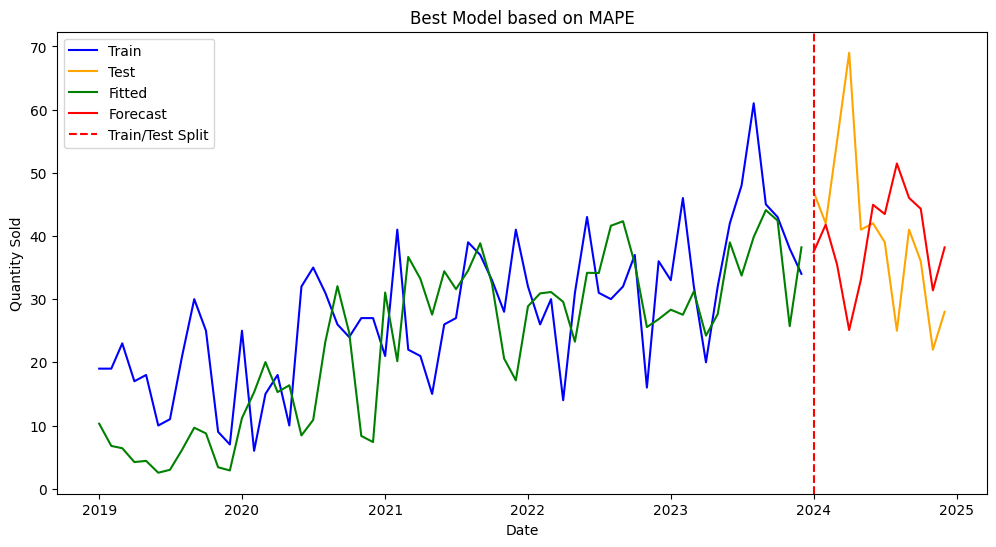

In [74]:
# Print the best model based on MAPE
print("Best Model based on MAPE: " + str(best_mape))
print(best_model_mape.summary())
print("===========================================")
# plot the best model based on MAPE
plt.figure(figsize=(12, 6))
plt.plot(train_series, label="Train", color="blue")
plt.plot(test_series, label="Test", color="orange")
plt.plot(best_model_mape.fittedvalues, label="Fitted", color="green")
plt.plot(best_model_mape.forecast(steps=12), label="Forecast", color="red")
plt.axvline(x=test_series.index[0], color="red", linestyle="--", label="Train/Test Split")
plt.title("Best Model based on MAPE")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.show()

### Combine all models and custom smoothing value

In [75]:
best_aic = float("inf") # the lowest aic is the best model
best_mape = float("inf") # the lowest mape is the best model

best_model_aic = None
best_model_mape = None

# fit the Holt-Winters model with auto smoothing parameters
for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            for trend, seasonal, damped_trend in model_combinations:
                try:
                    if trend == "mul" and seasonal == "add" and damped_trend:
                        continue
                    
                    initial_s = i_s_mul if seasonal == "mul" else i_s_add
                    forecast_model = HWES(
                        endog=train_series, 
                        seasonal_periods=12, 
                        trend=trend,
                        damped_trend=damped_trend,
                        seasonal=seasonal,
                        initialization_method="known",
                        initial_level=i_l,  # initial level
                        initial_trend=i_t,  # initial trend
                        initial_seasonal=initial_s,  # initial seasonal components (additive or multiplicative)
                    )
                    forecast_model_fit = forecast_model.fit(
                        smoothing_level=alpha,
                        smoothing_trend=beta,
                        smoothing_seasonal=gamma,
                        damping_trend=0.6 if damped_trend else None,
                        optimized=False,  # Disable auto-optimization
                    )
                    forecast = forecast_model_fit.forecast(steps=12)

                    # calculate the mean absolute error percentage
                    mape = mean_absolute_percentage_error(test_series, forecast)
                    aic = forecast_model_fit.aic

                    if aic < best_aic:
                        best_aic = aic
                        best_model_aic = forecast_model_fit
                    if mape < best_mape:
                        best_mape = mape
                        best_model_mape = forecast_model_fit
                except Exception as e:
                    # print(f"Error: {e}")
                    print(f"Skipping model with trend={trend}, seasonal={seasonal}, damped_trend={damped_trend}, i_l={i_l}, i_t={i_t}, i_s={initial_s}, alpha={alpha}, beta={beta}, gamma={gamma}")
                    continue

Best Model based on AIC: 296.90598986442916
                       ExponentialSmoothing Model Results                       
Dep. Variable:                 quantity   No. Observations:                   60
Model:             ExponentialSmoothing   SSE                           4961.406
Optimized:                        False   AIC                            296.906
Trend:                         Additive   BIC                            330.416
Seasonal:                      Additive   AICC                           313.589
Seasonal Periods:                    12   Date:                 Sat, 12 Apr 2025
Box-Cox:                          False   Time:                         22:25:57
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

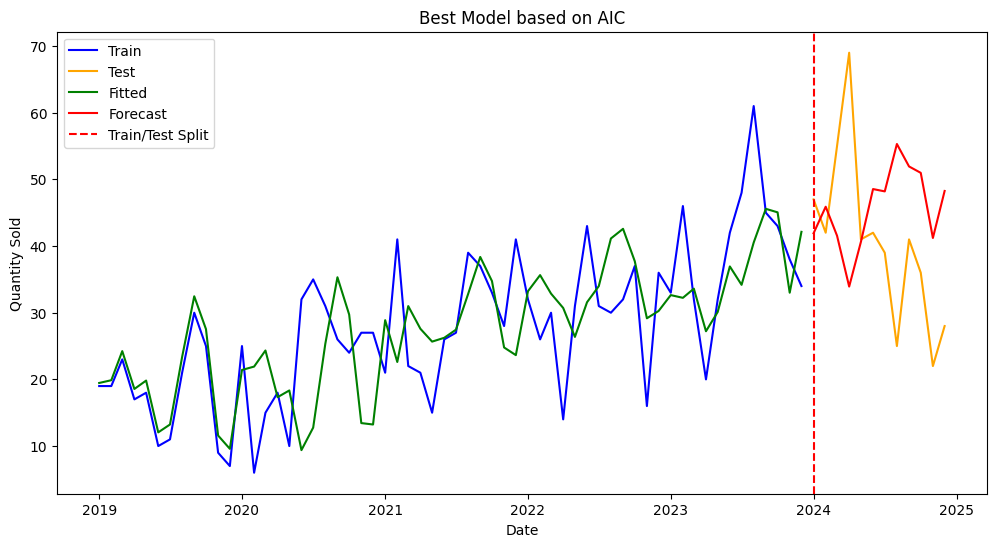

In [76]:
# Print the best model based on AIC
print("Best Model based on AIC: " + str(best_aic))
print(best_model_aic.summary())

print("===========================================")

# plot the best model based on AIC
plt.figure(figsize=(12, 6))
plt.plot(train_series, label="Train", color="blue")
plt.plot(test_series, label="Test", color="orange")
plt.plot(best_model_aic.fittedvalues, label="Fitted", color="green")
plt.plot(best_model_aic.forecast(steps=12), label="Forecast", color="red")
plt.axvline(x=test_series.index[0], color="red", linestyle="--", label="Train/Test Split")
plt.title("Best Model based on AIC")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.show()

Best Model based on MAPE: 0.14100763376481132
                       ExponentialSmoothing Model Results                       
Dep. Variable:                 quantity   No. Observations:                   60
Model:             ExponentialSmoothing   SSE                          12813.546
Optimized:                        False   AIC                            353.835
Trend:                   Multiplicative   BIC                            387.344
Seasonal:                      Additive   AICC                           370.518
Seasonal Periods:                    12   Date:                 Sat, 12 Apr 2025
Box-Cox:                          False   Time:                         22:26:02
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4000000                alpha 

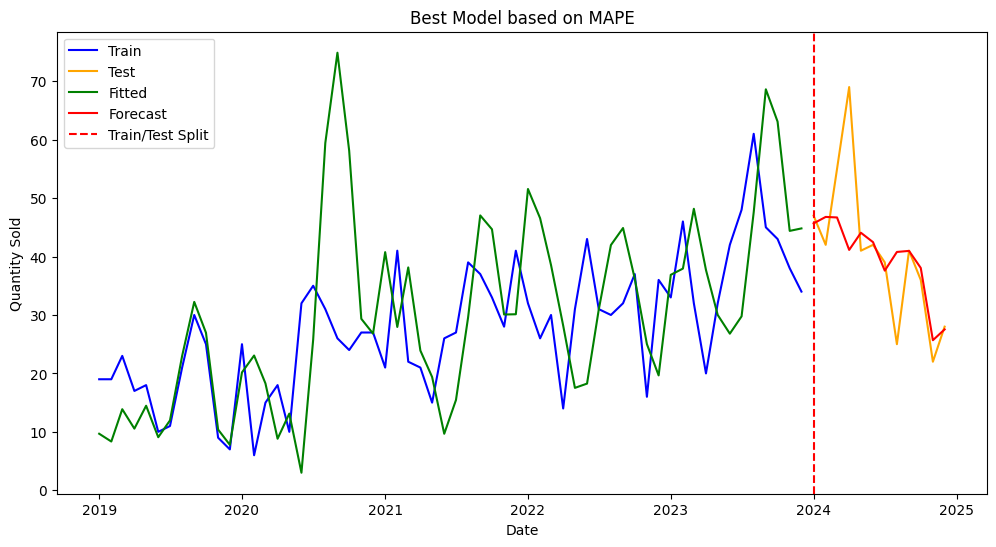

In [77]:
# Print the best model based on MAPE
print("Best Model based on MAPE: " + str(best_mape))
print(best_model_mape.summary())
print("===========================================")
# plot the best model based on MAPE
plt.figure(figsize=(12, 6))
plt.plot(train_series, label="Train", color="blue")
plt.plot(test_series, label="Test", color="orange")
plt.plot(best_model_mape.fittedvalues, label="Fitted", color="green")
plt.plot(best_model_mape.forecast(steps=12), label="Forecast", color="red")
plt.axvline(x=test_series.index[0], color="red", linestyle="--", label="Train/Test Split")
plt.title("Best Model based on MAPE")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.show()